In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import cv2
import gc
from tqdm import tqdm
from PIL import Image
from glob import glob
%matplotlib inline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [2]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df['Binary Labels'] = all_xray_df['Finding Labels'].map(lambda x: 0.0 if x == 'No Finding' else 1.0)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
88873,00022032_017.png,Effusion|Pleural_Thickening,17,22032,36,F,AP,3056,2544,0.139000,0.139000,NaN,../input/data/images_010/images/00022032_017.png,1.0
99021,00026194_000.png,Infiltration|Nodule,0,26194,10,F,PA,2544,3056,0.139000,0.139000,NaN,../input/data/images_011/images/00026194_000.png,1.0
96581,00025444_008.png,No Finding,8,25444,20,M,PA,2021,2021,0.194311,0.194311,NaN,../input/data/images_011/images/00025444_008.png,0.0


In [3]:
print('Before sampling...')
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)

print('After sampling...')
all_xray_df = all_xray_df.sample(22000, random_state=25)
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)
all_xray_df.sample(3)

Before sampling...
0.0    60361
1.0    51759
Name: Binary Labels, dtype: int64
After sampling...
0.0    11764
1.0    10236
Name: Binary Labels, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
71407,00017606_010.png,Effusion,10,17606,56,M,AP,2500,2048,0.168,0.168,NaN,../input/data/images_008/images/00017606_010.png,1.0
13075,00003404_000.png,No Finding,0,3404,31,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_002/images/00003404_000.png,0.0
12636,00003308_001.png,No Finding,1,3308,13,M,PA,2280,1796,0.143,0.143,NaN,../input/data/images_002/images/00003308_001.png,0.0


In [4]:
images = list(all_xray_df['path'])
labels = list(all_xray_df['Binary Labels'].map(lambda x: [x]))
train_img, val_img, train_label, val_label = train_test_split(images, labels, 
                                   test_size = 0.2, 
                                   random_state = 7,
                                   stratify = labels)
print('train:', len(train_img), '\nvalidation:', len(val_img))

train: 17600 
validation: 4400


In [5]:
class Net(nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.resnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.Linear_layer = nn.Sequential(nn.Linear(2048, 4096), 
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(4096, 2048),
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(2048, 1024),
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(1024, 512),
                                              nn.ReLU(),
                                              nn.Linear(512, 1))
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1)
        x = self.Linear_layer(x)
        x = self.out(x)
        return x

In [6]:
class my_set(Dataset):
    def __init__(self,Data,Label,transform=None):
        self.images = Data
        self.label = Label
        self.transform = transform
        
    def __getitem__(self, index):
        label = self.label[index]
        temp = cv2.imread(self.images[index])
        temp = np.array(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
        #print(self.images[index])
        try:
          temp = (temp * 255).round().astype(np.uint8)
        except:
          print(self.images[index])
        img = Image.fromarray(temp)
        if self.transform:
          img = self.transform(img)
        label = torch.Tensor([label])
        label = label.to(torch.float)
        return img, label
        
    def __len__(self):
        return len(self.images)

my_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

In [7]:
model = models.resnext50_32x4d(pretrained=True)
model = Net(model)
print(model)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

Net(
  (resnet_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [8]:
train = my_set(train_img, train_label, transform = my_transform)
trainloader = DataLoader(train, batch_size=32, shuffle=True, num_workers = 2)

val = my_set(val_img, val_label, transform = my_transform)
validloader = DataLoader(val, batch_size=32, shuffle=False, num_workers = 2)


valid_loss_min = np.Inf # track change in validation loss
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0002, momentum = 0.9 ,weight_decay=0.00002 )
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0002, weight_decay=0.00002 )
n_epochs = 10

train_ac = []
test_ac = []
t_loss = []
v_loss = []

In [9]:
print('CUDA:',torch.version.cuda)
device = torch.device("cuda")
model = model.to(device)
print(device)
gc.collect()
torch.cuda.empty_cache()

CUDA: 11.3
cuda


In [10]:
def training_loop(model):
    for epoch in tqdm(range(1, n_epochs+1)):
        train_loss = 0.0
        valid_loss = 0.0
        print('running epoch: {}'.format(epoch))
        model.train()
        train_correct = 0
        train_total = 0
        for data, target in trainloader:
            target = target.squeeze(1)
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            train_total += target.size(0)
            predicted = (output>0.5).float()
            train_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()

        # validate the model
        model.eval()
        valid_correct = 0
        valid_total = 0
        for data, target in validloader:
            target = target.squeeze(1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_total += target.size(0)
            predicted = (output>0.5).float()
            valid_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()
        # calculate average losses
        train_loss = train_loss/len(trainloader.dataset)
        valid_loss = valid_loss/len(validloader.dataset)
        t_loss.append(train_loss)
        v_loss.append(valid_loss)
        train_ac.append(100 * train_correct / train_total)
        test_ac.append(100 * valid_correct / valid_total) 

        print('Train Loss: {}'.format(train_loss))
        print('Validation Loss: {}'.format(valid_loss))
        print('Train Accuracy: {}'.format(100 * train_correct / train_total))
        print('Validation Accuracy: {}'.format(100 * valid_correct / valid_total))

In [11]:
training_loop(model)

  0%|          | 0/10 [00:00<?, ?it/s]

running epoch: 1


 10%|█         | 1/10 [14:49<2:13:25, 889.53s/it]

Train Loss: 0.6291288749738173
Validation Loss: 0.6143218059973283
Train Accuracy: 66.44318181818181
Validation Accuracy: 67.54545454545455
running epoch: 2


 20%|██        | 2/10 [29:07<1:56:09, 871.23s/it]

Train Loss: 0.6099396321448413
Validation Loss: 0.6333512451431969
Train Accuracy: 68.25
Validation Accuracy: 67.13636363636364
running epoch: 3


 30%|███       | 3/10 [42:59<1:39:32, 853.16s/it]

Train Loss: 0.6027904010902752
Validation Loss: 0.6044055487892844
Train Accuracy: 68.9659090909091
Validation Accuracy: 68.06818181818181
running epoch: 4


 40%|████      | 4/10 [56:50<1:24:27, 844.53s/it]

Train Loss: 0.5964782566915859
Validation Loss: 0.5995658600330352
Train Accuracy: 69.55681818181819
Validation Accuracy: 69.04545454545455
running epoch: 5


 50%|█████     | 5/10 [1:10:44<1:10:03, 840.76s/it]

Train Loss: 0.5893906335939061
Validation Loss: 0.6272071801532398
Train Accuracy: 70.0965909090909
Validation Accuracy: 67.02272727272727
running epoch: 6


 60%|██████    | 6/10 [1:24:33<55:46, 836.75s/it]  

Train Loss: 0.5892174258015372
Validation Loss: 0.6136541138995778
Train Accuracy: 69.95454545454545
Validation Accuracy: 68.75
running epoch: 7


 70%|███████   | 7/10 [1:38:42<42:01, 840.55s/it]

Train Loss: 0.5823969500173222
Validation Loss: 0.7305736437710849
Train Accuracy: 70.5965909090909
Validation Accuracy: 59.47727272727273
running epoch: 8


 80%|████████  | 8/10 [1:53:03<28:14, 847.03s/it]

Train Loss: 0.5783661825548518
Validation Loss: 0.6015034703774885
Train Accuracy: 70.88068181818181
Validation Accuracy: 69.52272727272727
running epoch: 9


 90%|█████████ | 9/10 [2:07:18<14:09, 849.53s/it]

Train Loss: 0.5744297463243658
Validation Loss: 0.604223871014335
Train Accuracy: 71.2784090909091
Validation Accuracy: 68.43181818181819
running epoch: 10


100%|██████████| 10/10 [2:21:21<00:00, 848.10s/it]

Train Loss: 0.5670695997368206
Validation Loss: 0.6046704355153171
Train Accuracy: 71.39772727272727
Validation Accuracy: 69.04545454545455


In [12]:
test_correct = 0
test_total = 0
pred_label = []
pred_for_roc_curve = []
for data, target in validloader:
    target = target.squeeze(1)
    data, target = data.to(device), target.to(device)
    out = model(data)
    predicted = (out>0.5).float()
    pred_label.extend(predicted.tolist())
    pred_for_roc_curve.extend(out.tolist())
    test_correct += (predicted == target).sum().item()
    test_total += target.size(0)
    del data
    gc.collect()
    torch.cuda.empty_cache()
print('Testing Auccracy: {}'.format((100 * test_correct / test_total)))
acu = (100 * test_correct / test_total)

Testing Auccracy: 69.20454545454545


In [13]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
model_confusion_matrix = confusion_matrix(val_label, pred_label)
model_confusion_matrix

array([[1696,  657],
       [ 698, 1349]])

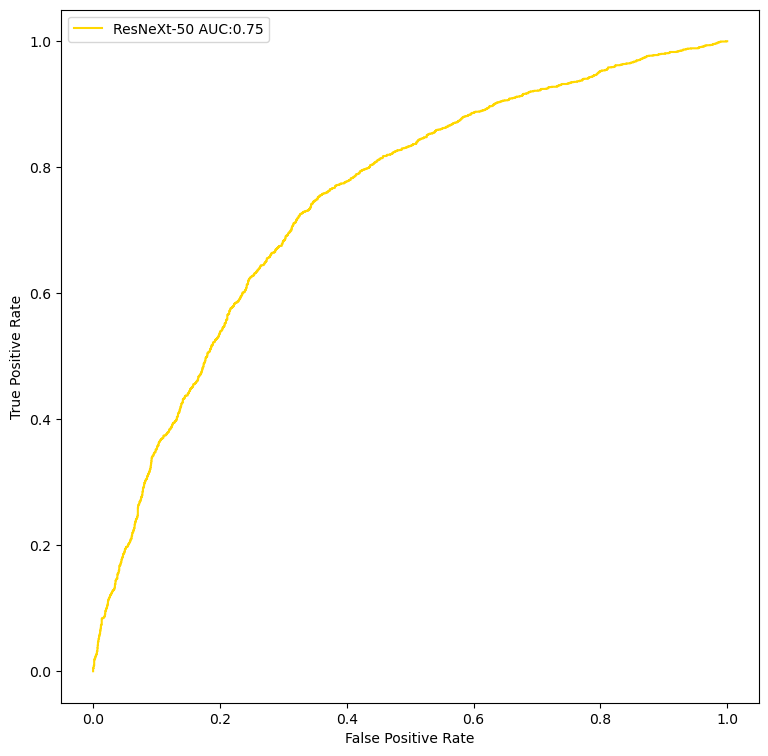

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score as acc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
fpr, tpr, thresholds = roc_curve(val_label, pred_for_roc_curve)
c_ax.plot(fpr, tpr, color='gold', label = 'ResNeXt-50 AUC:%0.2f'  % (auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig("plot1.png")

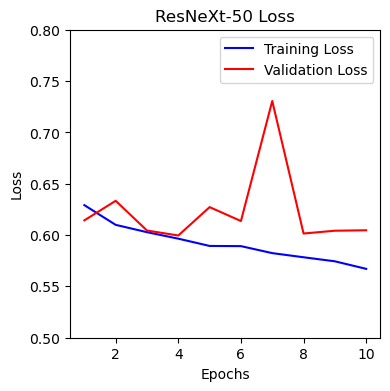

In [16]:
fig, c_ax = plt.subplots(1,1, figsize = (4, 4))
y = np.arange(1, n_epochs + 1)
c_ax.plot(y, t_loss, color='blue', label = 'Training Loss')
c_ax.plot(y, v_loss, color='red', label = 'Validation Loss')
c_ax.legend()
c_ax.set_xlabel('Epochs')
c_ax.set_title('ResNeXt-50 Loss')
plt.ylim([0.5, 0.8])
c_ax.set_ylabel('Loss')
plt.savefig("plot2.png")

fig, c_ax = plt.subplots(1,1, figsize = (9, 6))
y = np.arange(1, n_epochs + 1)
c_ax.plot(y, t_loss, color='blue', label = 'Training Loss')
c_ax.plot(y, v_loss, color='red', label = 'Validation Loss')
c_ax.legend()
c_ax.set_xlabel('Epochs')
plt.ylim([0.5, 0.8])
c_ax.set_ylabel('Loss')
plt.savefig("plot2.png")